In [1]:
keywords= ['c-myc'] #Multiple keywords can be typed in here
search_time_intended = 3650 #in days

#pip install geopy
#pip install folium
#pip install biopython
#pip install tqdm
#pip install pandas
#pip install wordcloud

In [2]:
import datetime
now = datetime.date.today()

for keyword1 in keywords:
    import sqlite3 #(keyword, years, country, journal, gene) -->years
    
    conn = sqlite3.connect('paper stats2.db')
    c = conn.cursor()
    c.execute("""CREATE TABLE IF NOT EXISTS stats (
    keyword text,
    years text,
    country text,
    journal text,
    gene text,
    date text
    )""")

    #commit the command
    conn.commit()
    c.execute("SELECT date FROM stats WHERE keyword=?",(keyword1,)) #LIKE '%123.com', = >= can be used as well
    items = c.fetchall()
    
n6=str(items)
n_date=n6[3:-4]

import time

    
if len(str(now)) == len(str(n_date)):
    database_date=time.strptime(n_date, '%Y-%m-%d')
    today_date=time.strptime(str(now), '%Y-%m-%d')
    date1=n_date
    date2=str(now)

    year1=int(date1[0:4])
    month1=int(date1[5:7])
    day1=int(date1[8:10])


    year2=int(date2[0:4])
    month2=int(date2[5:7])
    day2=int(date2[8:10])

    from datetime import date

    d0=date(year1,month1,day1)
    d1=date(year2,month2,day2)

    delta=d1-d0
    search_time=delta.days
    print('The search time is '+ str(search_time) +' days.')
        
else:
    search_time=search_time_intended
    print('The search time is '+ str(search_time) +' days.')

The search time is 16 days.


  0%|          | 0/9 [00:00<?, ?it/s]

Found 83 results


100%|██████████| 110138/110138 [00:16<00:00, 6807.56it/s]


This is the stats for c-myc
{'2019': 1676, '2016': 1634, '2018': 1607, '2017': 1601, '2015': 1515, '2020': 1164, '2014': 880, '2013': 6}


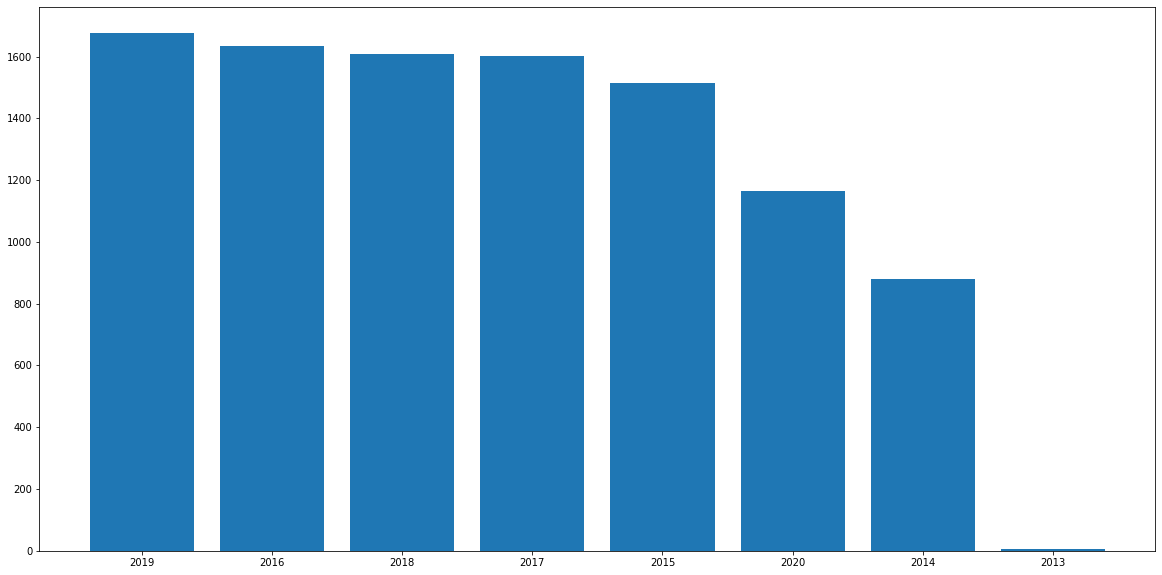

{'China': 3869, 'Japan': 589, 'Germany': 467, 'Italy': 368, 'Spain': 345, 'United States': 331, 'India': 323, 'Australia': 314, 'Canada': 261, 'France': 242}


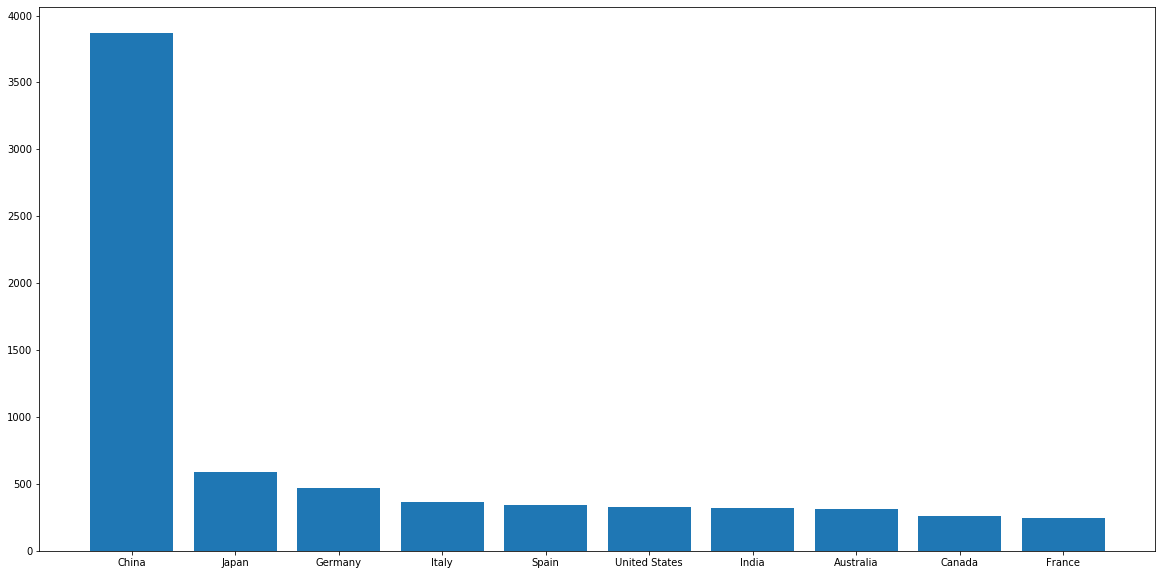

[('Oncotarget', 538), ('PloS one', 273), ('Scientific reports', 237), ('Oncogene', 159), ('Nature communications', 128)]
<class 'list'>


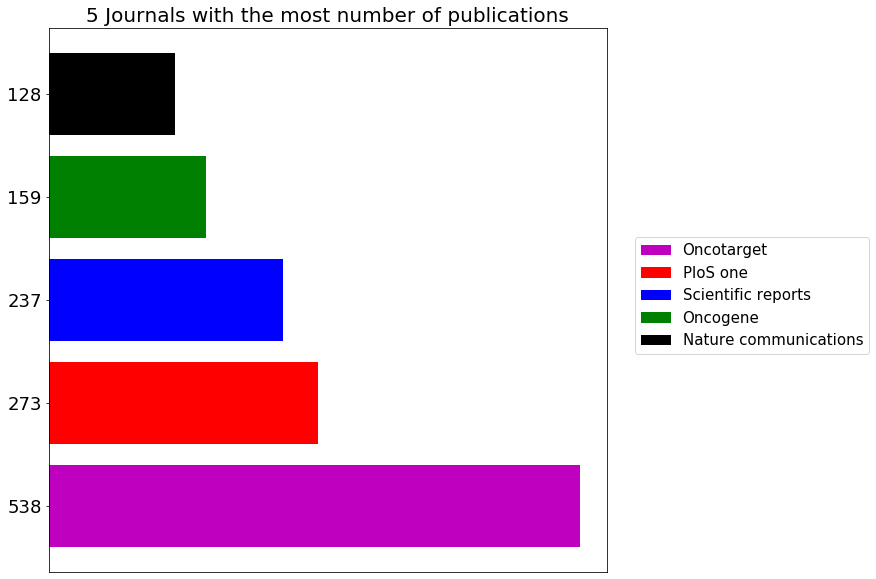

[('myc', 59696), ('stat3', 2302), ('sox2', 2156), ('mycn', 1932), ('bcl2', 1868), ('klf4', 1394), ('ar', 1291), ('nanog', 1231), ('mtor', 1203), ('max', 1181), ('si', 1129), ('pten', 1093), ('tp53', 1079), ('gc', 1040), ('egfr', 1016), ('brd4', 978), ('notch1', 824), ('kras', 809), ('ccnd1', 806), ('bcl6', 798)]


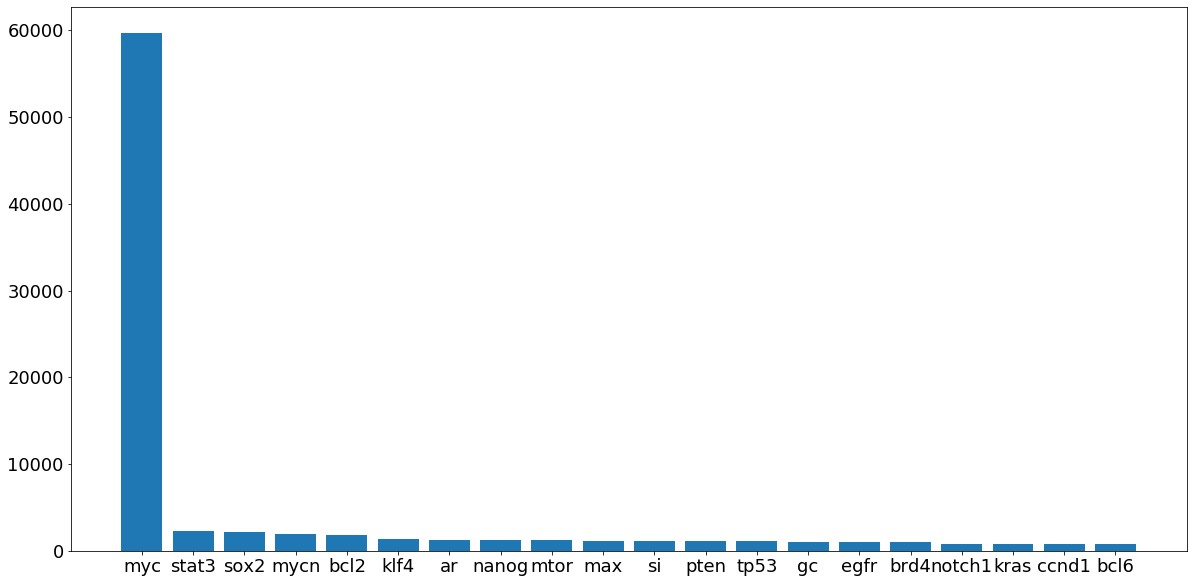

{'myc': 59696, 'stat3': 2302, 'sox2': 2156, 'mycn': 1932, 'bcl2': 1868, 'klf4': 1394, 'ar': 1291, 'nanog': 1231, 'mtor': 1203, 'max': 1181, 'si': 1129, 'pten': 1093, 'tp53': 1079, 'gc': 1040, 'egfr': 1016, 'brd4': 978, 'notch1': 824, 'kras': 809, 'ccnd1': 806, 'bcl6': 798}


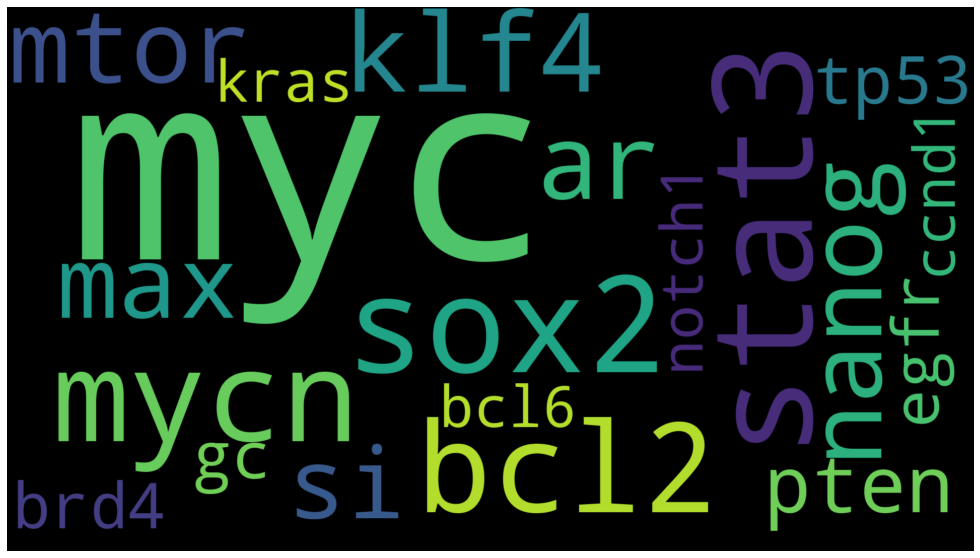

In [3]:
import sqlite3
import datetime
now = datetime.date.today()

conn = sqlite3.connect('paper stats2.db')

#create table (spreadsheet?) using cursor
c = conn.cursor()

#create table
c.execute("""CREATE TABLE IF NOT EXISTS stats (
    keyword text,
    years text,
    country text,
    journal text,
    gene text,
    date text
)""")

#commit the command
conn.commit()

#keyword is not found in database
for keyword1 in keywords:

    from Bio import Entrez #paper published last year about any gene
    from tqdm import tqdm
    import sqlite3 #(keyword, years, country, journal, gene) -->years
    conn = sqlite3.connect('paper stats2.db')
    c = conn.cursor()
    c.execute("SELECT keyword FROM stats")  #LIKE '%123.com', = >= can be used as well
    c1 = c.fetchall()

    out = [item for t in c1 for item in t] 
    

    if keyword1 not in out:
        Entrez.email = "michael_cic@gmail.com"

        #gene of interest (or anything of interest) can be changed here (term), and reldate can be changed
        search_results = Entrez.read(
            Entrez.esearch(
                db="pubmed", term=keyword1, reldate=search_time, datetype="pdat", usehistory="y"
            )
        )
        count = int(search_results["Count"])
        print("Found %i results" % count)

        batch_size = 10 #max limit of pubmed?

        out_handle = open("recent_papers.txt", "w") #name of file can be changed here
        for start in tqdm(range(0, count, batch_size)):
            end = min(count, start + batch_size)
            #print("Going to download record %i to %i" % (start + 1, end))
            fetch_handle = Entrez.efetch(
                db="pubmed",
                rettype="medline",
                retmode="text",
                retstart=start,
                retmax=batch_size,
                webenv=search_results["WebEnv"],
                query_key=search_results["QueryKey"],
            )
            data = fetch_handle.read()
            fetch_handle.close()
            out_handle.write(data)
        out_handle.close()

        handle = Entrez.esummary(db="pubmed", webenv=search_results["WebEnv"], query_key=search_results["QueryKey"],retmode="xml")
        records = Entrez.read(handle)

        gene_file=open('protein_coding_genes.txt', 'r')

        list_of_lists = []
        for line in gene_file:
            stripped_line = line.strip()
            line_list = stripped_line.split()
            list_of_lists.append(line_list)

        gene_file.close()

        #combine lists into 1 list

        flat_list = []
        for sublist in list_of_lists:
            for item in sublist:
                flat_list.append(item)

        #change into lower case
        flat_list=[x.lower() for x in flat_list]

        #compare the publications' abstract with the list of human genes (this takes some time)

        from tqdm import tqdm #progress bar
        from collections import Counter
        import re

        wanted = flat_list
        cnt = Counter()
        words = re.findall('\w+', open('recent_papers.txt').read().lower()) #remember to use the same file as above
        for word in tqdm(words):
            if word in wanted:
                cnt[word] += 1
        #print (cnt)

        #remove common words that are also a gene name (still more to be added)

        if 'fau' in cnt:
            del cnt['fau']
        if 'eng' in cnt:
            del cnt['eng']
        if 'was' in cnt:
            del cnt['was']
        if 'impact' in cnt:
            del cnt['impact']
        if 'nhs' in cnt:
            del cnt['nhs']
        if 'jun' in cnt:
            del cnt ['jun']
        if 'set' in cnt:
            del cnt ['set']
        if keyword1 in cnt:
            del cnt [keyword1]


        #display the results of high hits

        graph_data_gene={}

        #frequency can be changed here to refine the search
        for gene,frequency in cnt.items():
            if frequency>3:
               graph_data_gene.update({gene: frequency})
        #print (graph_data)

        #bar chart to show the result (cam be improved)

        import matplotlib.pyplot as plt


        sorted_graph_data_gene=sorted(graph_data_gene.items(), key=lambda kv:kv[1], reverse=True)
        twenty_sorted_genes=sorted_graph_data_gene[0:20]

        #print(twenty_sorted_genes)

        list_of_titles=[]
        for record in records:
            for key,value in record.items():
                if key == 'Title':
                    list_of_titles.append(value)

        list_of_authors=[]
        for record in records:
            for key, value in record.items():
                if key == 'LastAuthor':
                    list_of_authors.append(value)

        list_of_pubdates=[]
        for record in records:
            for key, value in record.items():
                if key == 'PubDate':
                    list_of_pubdates.append(value)

        list_of_lastauthors=[]
        for record in records:
            for key, value in record.items():
                if key == 'LastAuthor':
                    list_of_lastauthors.append(value)

        list_of_journalnames=[]
        for record in records:
            for key, value in record.items():
                if key == 'FullJournalName':
                    list_of_journalnames.append(value)
        import collections
        from collections import Counter

        count_journalnames = Counter(list_of_journalnames)
        graph_data_journal={}

        #frequency can be changed here to refine the search
        for journalname,frequency in count_journalnames.items():
            if frequency>=1:
               graph_data_journal.update({journalname: frequency})

        sorted_graph_data_journal=sorted(graph_data_journal.items(), key=lambda kv:kv[1], reverse=True)
        five_sorted_journals=sorted_graph_data_journal[0:5]
        a3=str(five_sorted_journals)


        import datetime
        nowtime = datetime.datetime.now()
        year1=nowtime.year+1

        item1=list(range(1900,year1))

        year_count=0
        year_of_pubdates = {}

        for item2 in item1:
            for item in list_of_pubdates:
                if str(item2) in item:
                    year_count +=1
                    year_of_pubdates[str(item2)]=year_count
            year_count=0


        from collections import OrderedDict
        dict1=year_of_pubdates
        dict2=OrderedDict(sorted(dict1.items(), reverse=True))

        n2=str(dict2)
        a1=n2[12:-1]
        



        import pycountry
        import collections
        from collections import Counter

        list_of_locations=[]

        with open("recent_papers.txt", "r") as f:
            searchlines = f.readlines()

        la1 = 'LA  - '
        for i, line in enumerate(searchlines):
            #for item in list_of_lastauthors:
            if la1 in line:
                for l in searchlines[i-3:i+1]:
                    #print (l)
                    for country in pycountry.countries:
                        if country.name in l:
                            list_of_locations.append(country.name)


        #print (list_of_locations)

        count_countries = Counter(list_of_locations)
        graph_data={}

        #frequency can be changed here to refine the search
        for country,frequency in count_countries.items():
            if frequency>=2:
               graph_data.update({country: frequency})

        sorted_graph_data_countries=sorted(graph_data.items(), key=lambda kv:kv[1], reverse=True)
        a2=str(sorted_graph_data_countries)

        a4=str(twenty_sorted_genes)

        #create database
        import sqlite3

        conn = sqlite3.connect('paper stats2.db')

        #create table (spreadsheet?) using cursor
        c = conn.cursor()

        #create table
        c.execute("""CREATE TABLE IF NOT EXISTS stats (
            keyword text,
            years text,
            country text,
            journal text,
            gene text,
            date text
        )""")

        #commit the command
        conn.commit()

        #app
        import sqlite3


        #query the db and return all records

        def show_all():
            conn = sqlite3.connect('paper stats2.db')

            #create table (spreadsheet?) using cursor
            c = conn.cursor()

            c.execute("SELECT rowid, * FROM stats") 
            items = c.fetchall()

            for item1 in items:
                print (item1)

            conn.commit()


        #a function to add a record to the database
        def add_one(keyword, years, country, journal,gene,date):
            conn = sqlite3.connect('paper stats2.db')
            c = conn.cursor()
            c.execute("INSERT INTO stats VALUES (?,?,?,?,?,?)", (keyword, years, country, journal,gene,date))
            conn.commit()


        #a function to delete a record from the database
        def delet_one(id):
            conn = sqlite3.connect('paper stats2.db')
            c = conn.cursor()
            c.execute("DELETE from stats WHERE rowid = (?)", id)
            conn.commit()

        #a function to add many record to the database
        def add_many_(list):
            conn = sqlite3.connect('paper stats2.db')
            c = conn.cursor()
            c.execute("INSERT INTO stats VALUES (?,?,?,?,?,?)", (list))
            conn.commit()

        import sqlite3 #(keyword, years, country, journal, gene) -->years

        conn = sqlite3.connect('paper stats2.db')
        c = conn.cursor()
        c.execute("SELECT keyword FROM stats")  #LIKE '%123.com', = >= can be used as well
        c1 = c.fetchall()

        out = [item for t in c1 for item in t] 

        if keyword1 not in out:
            conn = sqlite3.connect('paper stats2.db')
            c = conn.cursor()
            c.execute("INSERT INTO stats VALUES (?,?,?,?,?,?)", (keyword1, a1, a2, a3,a4,now))
            conn.commit()

        show_all()

        import sqlite3 #(keyword, years, country, journal, gene) -->years

        conn = sqlite3.connect('paper stats2.db')
        c = conn.cursor()
        c.execute("SELECT years FROM stats WHERE keyword=?", (keyword1,)) #LIKE '%123.com', = >= can be used as well
        items = c.fetchall()
        
        print ('This is the stats for '+ keyword1)
        n2=str(items)
        n_year=n2[3:-4]
        #print (n_year)
        #print(type(n_year)) #code run into error if only has 1 year

        import ast
        res1 = ast.literal_eval(n_year)

        def Convert(tup, di): 
            di = dict(tup) 
            return di

        # Driver Code     
        tups = res1
        dictionary = {} 
        dictionary.update(Convert(tups, dictionary))
        print(dictionary)
        import matplotlib.pyplot as plt

        plt.figure(figsize=(20,10))
        plt.bar(dictionary.keys(), dictionary.values())
        plt.show()

        import sqlite3 #(keyword, years, country, journal, gene)-->country

        conn = sqlite3.connect('paper stats2.db')
        c = conn.cursor()
        c.execute("SELECT country FROM stats WHERE keyword=?", (keyword1,)) #LIKE '%123.com', = >= can be used as well
        items = c.fetchall()
        n2=str(items)
        n_country=n2[3:-4]

        #figure from dictionary of data
        import ast
        res2 = ast.literal_eval(n_country)
        res=res2[0:10]

        def Convert(tup, di): 
            di = dict(tup) 
            return di

        # Driver Code     
        tups = res
        dictionary1 = {} 
        dictionary1.update(Convert(tups, dictionary1))
        print(dictionary1)

        import matplotlib.pyplot as plt

        plt.figure(figsize=(20,10))
        plt.bar(dictionary1.keys(), dictionary1.values())
        plt.show()
        
        import pycountry
        import collections
        from collections import Counter

        import csv
        with open ('test1.csv','w') as f:
            f.write("%s,%s\n"%('Countries', 'No. of publications'))
            for key in dictionary1.keys():
                f.write("%s,%s\n"%(key,dictionary1[key]))

        import pandas as pd
        import geopandas as gpd
        from shapely.geometry import Point
        %matplotlib inline


        df = pd.read_csv('test1.csv')
        df.head()

        
        import geopy
        from geopy.geocoders import Nominatim

        nom=Nominatim(user_agent="my-application1")

        #print (n.latitude, n.longitude)


        df['Coordinates']=df["Countries"].apply(nom.geocode)
        df['Latitude']=df['Coordinates'].apply(lambda x: x.latitude if x!= None else None)
        df['Longitude']=df['Coordinates'].apply(lambda x: x.longitude if x!= None else None)

        #pip install folium

        # Create a world map to show distributions of users 
        import folium
        from folium.plugins import MarkerCluster
        #empty map
        world_map= folium.Map(tiles="cartodbpositron")
        marker_cluster = MarkerCluster().add_to(world_map)
        #for each coordinate, create circlemarker of user percent
        for i in range(len(df)):
                lat = df.iloc[i]['Latitude']
                long = df.iloc[i]['Longitude']
                radius=int(df.iloc[i]['No. of publications'])
                popup_text = """Location : {}<br>
                            No. of publications : {}<br>"""
                popup_text = popup_text.format(df.iloc[i]['Countries'],
                                           df.iloc[i]['No. of publications']
                                           )
                folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
        #show the map
        display(world_map)
        
        import sqlite3 #(keyword, years, country, journal, gene) -->journal

        conn = sqlite3.connect('paper stats2.db')
        c = conn.cursor()
        c.execute("SELECT journal FROM stats WHERE keyword=?", (keyword1,)) #LIKE '%123.com', = >= can be used as well
        items = c.fetchall()
        n2=str(items)
        n_journal=n2[3:-4]

        import ast
        res = ast.literal_eval(n_journal)
        print(res)
        print(type(res))

        #figure from list of data
        import numpy as np                                                               
        import matplotlib.pyplot as plt

        five_sorted_journals=res[0:5]
        labels, ys = zip(*five_sorted_journals)
        xs = np.arange(len(labels)) 
        plt.figure(figsize=(10,10))
        b=plt.barh(xs, ys, height= 0.8,color=('m','r','b','g','k'))

        plt.title('5 Journals with the most number of publications', fontsize=20)
        #plt.xticks(ys, fontsize=18) #Replace default x-ticks with xs, then replace xs with labels
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.yticks(xs,ys, fontsize=18)

        plt.legend(b,labels, fontsize=15, loc=(1.05,0.4))
        plt.show()

        import sqlite3 #(keyword, years, country, journal, gene) -->gene

        conn = sqlite3.connect('paper stats2.db')
        c = conn.cursor()
        c.execute("SELECT gene FROM stats WHERE keyword=?", (keyword1,)) #LIKE '%123.com', = >= can be used as well
        items = c.fetchall()
        n2=str(items)
        n_gene=n2[3:-4]

        import ast
        res4 = ast.literal_eval(n_gene)
        print(res4)

        plt.figure(figsize=(20,10))
        labels, ys = zip(*res4)
        xs = np.arange(len(labels)) 
        plt.bar(xs, ys)
        plt.xticks(xs, labels, fontsize=18)
        plt.yticks(fontsize=18)

        plt.show()


        def Convert(tup, di): 
            di = dict(tup) 
            return di

        # Driver Code     
        tups = res4
        dictionary4 = {} 
        dictionary4.update(Convert(tups, dictionary4))
        print(dictionary4)

        #write the comparsion result into a text file for display in wordcloud

        with open('myfile.txt', 'w') as f:
            for genes,value in dictionary4.items():
                while value >0:
                    print (genes, file=f)
                    value-=1

        import os

        from os import path
        from wordcloud import WordCloud

        # get data directory 
        d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

        # Read the whole text.
        text = open(path.join(d, 'myfile.txt')).read()

        # Generate a word cloud image
        wordcloud = WordCloud(width=1920, height=1080, collocations = False).generate(text)

        # Display the generated image:
        # the matplotlib way:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(20,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        

    elif keyword1 in out and search_time==0:
        import sqlite3 #(keyword, years, country, journal, gene) -->years

        conn = sqlite3.connect('paper stats2.db')
        c = conn.cursor()
        c.execute("SELECT years FROM stats WHERE keyword=?", (keyword1,)) #LIKE '%123.com', = >= can be used as well
        items = c.fetchall()
        
        print ('This is the stats for '+ keyword1)
        n2=str(items)
        n_year=n2[3:-4]
        #print (n_year)
        #print(type(n_year)) #code run into error if only has 1 year

        import ast
        res1 = ast.literal_eval(n_year)

        def Convert(tup, di): 
            di = dict(tup) 
            return di

        # Driver Code     
        tups = res1
        dictionary = {} 
        dictionary.update(Convert(tups, dictionary))
        print(dictionary)
        import matplotlib.pyplot as plt

        plt.figure(figsize=(20,10))
        plt.bar(dictionary.keys(), dictionary.values())
        plt.show()

        import sqlite3 #(keyword, years, country, journal, gene)-->country

        conn = sqlite3.connect('paper stats2.db')
        c = conn.cursor()
        c.execute("SELECT country FROM stats WHERE keyword=?", (keyword1,)) #LIKE '%123.com', = >= can be used as well
        items = c.fetchall()
        n2=str(items)
        n_country=n2[3:-4]

        #figure from dictionary of data
        import ast
        res2 = ast.literal_eval(n_country)
        res=res2[0:10]

        def Convert(tup, di): 
            di = dict(tup) 
            return di

        # Driver Code     
        tups = res
        dictionary1 = {} 
        dictionary1.update(Convert(tups, dictionary1))
        print(dictionary1)

        import matplotlib.pyplot as plt

        plt.figure(figsize=(20,10))
        plt.bar(dictionary1.keys(), dictionary1.values())
        plt.show()
        
        import pycountry
        import collections
        from collections import Counter

        import csv
        with open ('test1.csv','w') as f:
            f.write("%s,%s\n"%('Countries', 'No. of publications'))
            for key in dictionary1.keys():
                f.write("%s,%s\n"%(key,dictionary1[key]))

        import pandas as pd
        import geopandas as gpd
        from shapely.geometry import Point
        %matplotlib inline


        df = pd.read_csv('test1.csv')
        df.head()

        #pip install geopy
        import geopy
        from geopy.geocoders import Nominatim

        nom=Nominatim(user_agent="my-application1")

        #print (n.latitude, n.longitude)


        df['Coordinates']=df["Countries"].apply(nom.geocode)
        df['Latitude']=df['Coordinates'].apply(lambda x: x.latitude if x!= None else None)
        df['Longitude']=df['Coordinates'].apply(lambda x: x.longitude if x!= None else None)

        #pip install folium

        # Create a world map to show distributions of users 
        import folium
        from folium.plugins import MarkerCluster
        #empty map
        world_map= folium.Map(tiles="cartodbpositron")
        marker_cluster = MarkerCluster().add_to(world_map)
        #for each coordinate, create circlemarker of user percent
        for i in range(len(df)):
                lat = df.iloc[i]['Latitude']
                long = df.iloc[i]['Longitude']
                radius=int(df.iloc[i]['No. of publications'])
                popup_text = """Location : {}<br>
                            No. of publications : {}<br>"""
                popup_text = popup_text.format(df.iloc[i]['Countries'],
                                           df.iloc[i]['No. of publications']
                                           )
                folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
        #show the map
        display(world_map)
        
        import sqlite3 #(keyword, years, country, journal, gene) -->journal

        conn = sqlite3.connect('paper stats2.db')
        c = conn.cursor()
        c.execute("SELECT journal FROM stats WHERE keyword=?", (keyword1,)) #LIKE '%123.com', = >= can be used as well
        items = c.fetchall()
        n2=str(items)
        n_journal=n2[3:-4]

        import ast
        res = ast.literal_eval(n_journal)
        print(res)
        print(type(res))

        #figure from list of data
        import numpy as np                                                               
        import matplotlib.pyplot as plt

        five_sorted_journals=res[0:5]
        labels, ys = zip(*five_sorted_journals)
        xs = np.arange(len(labels)) 
        plt.figure(figsize=(10,10))
        b=plt.barh(xs, ys, height= 0.8,color=('m','r','b','g','k'))

        plt.title('5 Journals with the most number of publications', fontsize=20)
        #plt.xticks(ys, fontsize=18) #Replace default x-ticks with xs, then replace xs with labels
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.yticks(xs,ys, fontsize=18)

        plt.legend(b,labels, fontsize=15, loc=(1.05,0.4))
        plt.show()

        import sqlite3 #(keyword, years, country, journal, gene) -->gene

        conn = sqlite3.connect('paper stats2.db')
        c = conn.cursor()
        c.execute("SELECT gene FROM stats WHERE keyword=?", (keyword1,)) #LIKE '%123.com', = >= can be used as well
        items = c.fetchall()
        n2=str(items)
        n_gene=n2[3:-4]

        import ast
        res4 = ast.literal_eval(n_gene)
        print(res4)

        plt.figure(figsize=(20,10))
        labels, ys = zip(*res4)
        xs = np.arange(len(labels)) 
        plt.bar(xs, ys)
        plt.xticks(xs, labels, fontsize=18)
        plt.yticks(fontsize=18)

        plt.show()


        def Convert(tup, di): 
            di = dict(tup) 
            return di

        # Driver Code     
        tups = res4
        dictionary4 = {} 
        dictionary4.update(Convert(tups, dictionary4))
        print(dictionary4)

        #write the comparsion result into a text file for display in wordcloud

        with open('myfile.txt', 'w') as f:
            for genes,value in dictionary4.items():
                while value >0:
                    print (genes, file=f)
                    value-=1

        import os

        from os import path
        from wordcloud import WordCloud

        # get data directory 
        d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

        # Read the whole text.
        text = open(path.join(d, 'myfile.txt')).read()

        # Generate a word cloud image
        wordcloud = WordCloud(width=1920, height=1080, collocations = False).generate(text)

        # Display the generated image:
        # the matplotlib way:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(20,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        

    elif keyword1 in out and search_time>0:
        Entrez.email = "michael_cic@163.com"

        #gene of interest (or anything of interest) can be changed here (term), and reldate can be changed
        search_results = Entrez.read(
            Entrez.esearch(
                db="pubmed", term=keyword1, reldate=search_time, datetype="pdat", usehistory="y"
            )
        )
        count = int(search_results["Count"])
        print("Found %i results" % count)

        batch_size = 10 #max limit of pubmed?

        out_handle = open("recent_papers.txt", "w") #name of file can be changed here
        for start in tqdm(range(0, count, batch_size)):
            end = min(count, start + batch_size)
            #print("Going to download record %i to %i" % (start + 1, end))
            fetch_handle = Entrez.efetch(
                db="pubmed",
                rettype="medline",
                retmode="text",
                retstart=start,
                retmax=batch_size,
                webenv=search_results["WebEnv"],
                query_key=search_results["QueryKey"],
            )
            data = fetch_handle.read()
            fetch_handle.close()
            out_handle.write(data)
        out_handle.close()

        handle = Entrez.esummary(db="pubmed", webenv=search_results["WebEnv"], query_key=search_results["QueryKey"],retmode="xml")
        records = Entrez.read(handle)

        gene_file=open('protein_coding_genes.txt', 'r')

        list_of_lists = []
        for line in gene_file:
            stripped_line = line.strip()
            line_list = stripped_line.split()
            list_of_lists.append(line_list)

        gene_file.close()

        #combine lists into 1 list

        flat_list = []
        for sublist in list_of_lists:
            for item in sublist:
                flat_list.append(item)

        #change into lower case
        flat_list=[x.lower() for x in flat_list]

        #compare the publications' abstract with the list of human genes (this takes some time)

        from tqdm import tqdm #progress bar
        from collections import Counter
        import re

        wanted = flat_list
        cnt = Counter()
        words = re.findall('\w+', open('recent_papers.txt').read().lower()) #remember to use the same file as above
        for word in tqdm(words):
            if word in wanted:
                cnt[word] += 1
        #print (cnt)

        #remove common words that are also a gene name (still more to be added)

        if 'fau' in cnt:
            del cnt['fau']
        if 'eng' in cnt:
            del cnt['eng']
        if 'was' in cnt:
            del cnt['was']
        if 'impact' in cnt:
            del cnt['impact']
        if 'nhs' in cnt:
            del cnt['nhs']
        if 'jun' in cnt:
            del cnt ['jun']
        if 'set' in cnt:
            del cnt ['set']
        if keyword1 in cnt:
            del cnt [keyword1]


        #display the results of high hits

        graph_data_gene={}

        #frequency can be changed here to refine the search
        for gene,frequency in cnt.items():
            if frequency>3:
               graph_data_gene.update({gene: frequency})
        #print (graph_data)

        #bar chart to show the result (cam be improved)

        import matplotlib.pyplot as plt


        sorted_graph_data_gene=sorted(graph_data_gene.items(), key=lambda kv:kv[1], reverse=True)
        twenty_sorted_genes=sorted_graph_data_gene[0:20]

        #print(twenty_sorted_genes)

        list_of_titles=[]
        for record in records:
            for key,value in record.items():
                if key == 'Title':
                    list_of_titles.append(value)

        list_of_authors=[]
        for record in records:
            for key, value in record.items():
                if key == 'LastAuthor':
                    list_of_authors.append(value)

        list_of_pubdates=[]
        for record in records:
            for key, value in record.items():
                if key == 'PubDate':
                    list_of_pubdates.append(value)

        list_of_lastauthors=[]
        for record in records:
            for key, value in record.items():
                if key == 'LastAuthor':
                    list_of_lastauthors.append(value)

        list_of_journalnames=[]
        for record in records:
            for key, value in record.items():
                if key == 'FullJournalName':
                    list_of_journalnames.append(value)
        import collections
        from collections import Counter

        count_journalnames = Counter(list_of_journalnames)
        graph_data_journal={}

        #frequency can be changed here to refine the search
        for journalname,frequency in count_journalnames.items():
            if frequency>=1:
               graph_data_journal.update({journalname: frequency})

        sorted_graph_data_journal=sorted(graph_data_journal.items(), key=lambda kv:kv[1], reverse=True)
        five_sorted_journals=sorted_graph_data_journal[0:5]
        #a3=str(five_sorted_journals)


        import datetime
        nowtime = datetime.datetime.now()
        year1=nowtime.year+1

        item1=list(range(1900,year1))

        year_count=0
        year_of_pubdates = {}

        for item2 in item1:
            for item in list_of_pubdates:
                if str(item2) in item:
                    year_count +=1
                    year_of_pubdates[str(item2)]=year_count
            year_count=0


        from collections import OrderedDict
        dict1=year_of_pubdates
        dict2=OrderedDict(sorted(dict1.items(), reverse=True))

        n2=str(dict2)
        #a1=n2[12:-1]
        

        import pycountry
        import collections
        from collections import Counter

        list_of_locations=[]

        with open("recent_papers.txt", "r") as f:
            searchlines = f.readlines()

        la1 = 'LA  - '
        for i, line in enumerate(searchlines):
            #for item in list_of_lastauthors:
            if la1 in line:
                for l in searchlines[i-3:i+1]:
                    #print (l)
                    for country in pycountry.countries:
                        if country.name in l:
                            list_of_locations.append(country.name)


        #print (list_of_locations)

        count_countries = Counter(list_of_locations)
        graph_data={}

        #frequency can be changed here to refine the search
        for country,frequency in count_countries.items():
            if frequency>=2:
               graph_data.update({country: frequency})



        #a4=str(twenty_sorted_genes)

        #create database
        import sqlite3

        conn = sqlite3.connect('paper stats2.db')

        #create table (spreadsheet?) using cursor
        c = conn.cursor()

        #create table
        c.execute("""CREATE TABLE IF NOT EXISTS stats (
            keyword text,
            years text,
            country text,
            journal text,
            gene text,
            date text
        )""")

        #commit the command
        conn.commit()

        #app
        import sqlite3


        #query the db and return all records

        def show_all():
            conn = sqlite3.connect('paper stats2.db')

            #create table (spreadsheet?) using cursor
            c = conn.cursor()

            c.execute("SELECT rowid, * FROM stats") 
            items = c.fetchall()

            for item1 in items:
                print (item1)

            conn.commit()


        #a function to add a record to the database
        def add_one(keyword, years, country, journal,gene,date):
            conn = sqlite3.connect('paper stats2.db')
            c = conn.cursor()
            c.execute("INSERT INTO stats VALUES (?,?,?,?,?,?)", (keyword, years, country, journal,gene,date))
            conn.commit()


        #a function to delete a record from the database
        def delet_one(id):
            conn = sqlite3.connect('paper stats2.db')
            c = conn.cursor()
            c.execute("DELETE from stats WHERE rowid = (?)", id)
            conn.commit()

        #a function to add many record to the database
        def add_many_(list):
            conn = sqlite3.connect('paper stats2.db')
            c = conn.cursor()
            c.execute("INSERT INTO stats VALUES (?,?,?,?,?,?)", (list))
            conn.commit()

        import sqlite3 #(keyword, years, country, journal, gene) -->years

        conn = sqlite3.connect('paper stats2.db')
        c = conn.cursor()
        c.execute("SELECT keyword FROM stats")  #LIKE '%123.com', = >= can be used as well
        c1 = c.fetchall()

        out = [item for t in c1 for item in t] 

        #old data from the database --> go on from here
        #old data from the database --> merge from here
        import sqlite3 #(keyword, years, country, journal, gene)-->country

        conn = sqlite3.connect('paper stats2.db')
        c = conn.cursor()
        c.execute("SELECT country FROM stats WHERE keyword=?", (keyword1,)) #LIKE '%123.com', = >= can be used as well
        items = c.fetchall()
        n2=str(items)
        n_country=n2[3:-4]

        #figure from dictionary of data
        import ast
        res2 = ast.literal_eval(n_country)
        res=res2[0:10]

        def Convert(tup, di): 
            di = dict(tup) 
            return di

        # Driver Code     
        tups = res
        dictionary1 = {} 
        dictionary1.update(Convert(tups, dictionary1))
        #print(dictionary1)
        #print(graph_data)


        def mergeDict(dict1, dict2):
           dict3 = {**dict1, **dict2}
           for key, value in dict3.items():
               if key in dict1 and key in dict2:
                   dict3[key] = value+dict1[key]
           return dict3
        # Merge dictionaries and add values of common keys in a list
        dict_a2 = mergeDict(graph_data,dictionary1)
        #print('Dictionary 3 :')
        #print(dict_a2)
        sorted_graph_data_countries=sorted(dict_a2.items(), key=lambda kv:kv[1], reverse=True)
        a2=str(sorted_graph_data_countries)
        #print(a2)
        #update country done!!!
        
        #old data from the database --> merge from here
        import sqlite3 #(keyword, years, country, journal, gene) -->years

        conn = sqlite3.connect('paper stats2.db')
        c = conn.cursor()
        c.execute("SELECT years FROM stats WHERE keyword=?", (keyword1,)) #LIKE '%123.com', = >= can be used as well
        items = c.fetchall()

        print ('This is the stats for '+ keyword1)
        n2=str(items)
        n_year=n2[3:-4]
        #print (n_year)
        #print(type(n_year)) #code run into error if only has 1 year

        import ast
        res1 = ast.literal_eval(n_year)

        def Convert(tup, di): 
            di = dict(tup) 
            return di

        # Driver Code     
        tups = res1
        dictionary = {} 
        dictionary.update(Convert(tups, dictionary))
        #print(dictionary)

        import datetime
        nowtime = datetime.datetime.now()
        year1=nowtime.year+1

        item1=list(range(1900,year1))

        year_count=0
        year_of_pubdates = {}

        for item2 in item1:
            for item in list_of_pubdates:
                if str(item2) in item:
                    year_count +=1
                    year_of_pubdates[str(item2)]=year_count
            year_count=0


        from collections import OrderedDict
        dict1=year_of_pubdates
        dict2=OrderedDict(sorted(dict1.items(), reverse=True))


        def mergeDict(dict1, dict2):
           dict3 = {**dict1, **dict2}
           for key, value in dict3.items():
               if key in dict1 and key in dict2:
                   dict3[key] = value+dict1[key]
           return dict3
        # Merge dictionaries and add values of common keys in a list
        dict_a1 = mergeDict(dict2,dictionary)
        #print('Dictionary 3 :')
        #print(dict_a1)

        sorted_graph_data_year=sorted(dict_a1.items(), key=lambda kv:kv[1], reverse=True)
        a1=str(sorted_graph_data_year)
        #print(a1)
        #update year done!!!
        
        #old data from the database --> merge from here
        import sqlite3 #(keyword, years, country, journal, gene) -->journal

        conn = sqlite3.connect('paper stats2.db')
        c = conn.cursor()
        c.execute("SELECT journal FROM stats WHERE keyword=?", (keyword1,)) #LIKE '%123.com', = >= can be used as well
        items = c.fetchall()
        n2=str(items)
        n_journal=n2[3:-4]

        import ast
        res = ast.literal_eval(n_journal)
        #print(res)

        def Convert(tup, di): 
            di = dict(tup) 
            return di

        # Driver Code     
        tups = res
        dictionary = {} 
        dictionary.update(Convert(tups, dictionary))

        def mergeDict(dict1, dict2):
           dict3 = {**dict1, **dict2}
           for key, value in dict3.items():
               if key in dict1 and key in dict2:
                   dict3[key] = value+dict1[key]
           return dict3
        # Merge dictionaries and add values of common keys in a list
        dict_a3 = mergeDict(dictionary,graph_data_journal)

        sorted_graph_data_journal=sorted(dict_a3.items(), key=lambda kv:kv[1], reverse=True)
        five_sorted_journals=sorted_graph_data_journal[0:5]
        a3=str(five_sorted_journals)
        #print(a3)
        
        #old data from the database --> merge from here
        import sqlite3 #(keyword, years, country, journal, gene) -->gene

        conn = sqlite3.connect('paper stats2.db')
        c = conn.cursor()
        c.execute("SELECT gene FROM stats WHERE keyword=?", (keyword1,)) #LIKE '%123.com', = >= can be used as well
        items = c.fetchall()
        n2=str(items)
        n_gene=n2[3:-4]

        import ast
        res4 = ast.literal_eval(n_gene)

        def Convert(tup, di): 
            di = dict(tup) 
            return di

        # Driver Code     
        tups = res4
        dictionary4 = {} 
        dictionary4.update(Convert(tups, dictionary4))

        def mergeDict(dict1, dict2):
           dict3 = {**dict1, **dict2}
           for key, value in dict3.items():
               if key in dict1 and key in dict2:
                   dict3[key] = value+dict1[key]
           return dict3
        # Merge dictionaries and add values of common keys in a list
        dict_a4 = mergeDict(dictionary4,graph_data_gene)
        #print(dict_a4)

        sorted_graph_data_gene=sorted(dict_a4.items(), key=lambda kv:kv[1], reverse=True)
        twenty_sorted_genes=sorted_graph_data_gene[0:20]
        a4=str(twenty_sorted_genes)
        #print(a4)
        
        conn = sqlite3.connect('paper stats2.db')
        c = conn.cursor()
        c.execute("DELETE from stats WHERE keyword=?", (keyword1,))
        conn.commit()
        
        conn = sqlite3.connect('paper stats2.db')
        c = conn.cursor()
        c.execute("INSERT INTO stats VALUES (?,?,?,?,?,?)", (keyword1, a1, a2, a3,a4,now))
        conn.commit()
        
        import sqlite3 #(keyword, years, country, journal, gene) -->years

        conn = sqlite3.connect('paper stats2.db')
        c = conn.cursor()
        c.execute("SELECT years FROM stats WHERE keyword=?", (keyword1,)) #LIKE '%123.com', = >= can be used as well
        items = c.fetchall()

        n2=str(items)
        n_year=n2[3:-4]
        #print (n_year)
        #print(type(n_year)) #code run into error if only has 1 year

        import ast
        res1 = ast.literal_eval(n_year)

        def Convert(tup, di): 
            di = dict(tup) 
            return di

        # Driver Code     
        tups = res1
        dictionary = {} 
        dictionary.update(Convert(tups, dictionary))
        print(dictionary)
        import matplotlib.pyplot as plt

        plt.figure(figsize=(20,10))
        plt.bar(dictionary.keys(), dictionary.values())
        plt.show()

        import sqlite3 #(keyword, years, country, journal, gene)-->country

        conn = sqlite3.connect('paper stats2.db')
        c = conn.cursor()
        c.execute("SELECT country FROM stats WHERE keyword=?", (keyword1,)) #LIKE '%123.com', = >= can be used as well
        items = c.fetchall()
        n2=str(items)
        n_country=n2[3:-4]

        #figure from dictionary of data
        import ast
        res2 = ast.literal_eval(n_country)
        res=res2[0:10]

        def Convert(tup, di): 
            di = dict(tup) 
            return di

        # Driver Code     
        tups = res
        dictionary1 = {} 
        dictionary1.update(Convert(tups, dictionary1))
        print(dictionary1)

        import matplotlib.pyplot as plt

        plt.figure(figsize=(20,10))
        plt.bar(dictionary1.keys(), dictionary1.values())
        plt.show()

        import pycountry
        import collections
        from collections import Counter

        import csv
        with open ('test1.csv','w') as f:
            f.write("%s,%s\n"%('Countries', 'No. of publications'))
            for key in dictionary1.keys():
                f.write("%s,%s\n"%(key,dictionary1[key]))

        import pandas as pd
        import geopandas as gpd
        from shapely.geometry import Point
        %matplotlib inline


        df = pd.read_csv('test1.csv')
        df.head()

        #pip install geopy
        import geopy
        from geopy.geocoders import Nominatim

        nom=Nominatim(user_agent="my-application1")

        #print (n.latitude, n.longitude)


        df['Coordinates']=df["Countries"].apply(nom.geocode)
        df['Latitude']=df['Coordinates'].apply(lambda x: x.latitude if x!= None else None)
        df['Longitude']=df['Coordinates'].apply(lambda x: x.longitude if x!= None else None)

        #pip install folium

        # Create a world map to show distributions of users 
        import folium
        from folium.plugins import MarkerCluster
        #empty map
        world_map= folium.Map(tiles="cartodbpositron")
        marker_cluster = MarkerCluster().add_to(world_map)
        #for each coordinate, create circlemarker of user percent
        for i in range(len(df)):
                lat = df.iloc[i]['Latitude']
                long = df.iloc[i]['Longitude']
                radius=int(df.iloc[i]['No. of publications'])
                popup_text = """Location : {}<br>
                            No. of publications : {}<br>"""
                popup_text = popup_text.format(df.iloc[i]['Countries'],
                                           df.iloc[i]['No. of publications']
                                           )
                folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
        #show the map
        display(world_map)

        import sqlite3 #(keyword, years, country, journal, gene) -->journal

        conn = sqlite3.connect('paper stats2.db')
        c = conn.cursor()
        c.execute("SELECT journal FROM stats WHERE keyword=?", (keyword1,)) #LIKE '%123.com', = >= can be used as well
        items = c.fetchall()
        n2=str(items)
        n_journal=n2[3:-4]

        import ast
        res = ast.literal_eval(n_journal)
        print(res)
        print(type(res))

        #figure from list of data
        import numpy as np                                                               
        import matplotlib.pyplot as plt

        five_sorted_journals=res[0:5]
        labels, ys = zip(*five_sorted_journals)
        xs = np.arange(len(labels)) 
        plt.figure(figsize=(10,10))
        b=plt.barh(xs, ys, height= 0.8,color=('m','r','b','g','k'))

        plt.title('5 Journals with the most number of publications', fontsize=20)
        #plt.xticks(ys, fontsize=18) #Replace default x-ticks with xs, then replace xs with labels
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.yticks(xs,ys, fontsize=18)

        plt.legend(b,labels, fontsize=15, loc=(1.05,0.4))
        plt.show()

        import sqlite3 #(keyword, years, country, journal, gene) -->gene

        conn = sqlite3.connect('paper stats2.db')
        c = conn.cursor()
        c.execute("SELECT gene FROM stats WHERE keyword=?", (keyword1,)) #LIKE '%123.com', = >= can be used as well
        items = c.fetchall()
        n2=str(items)
        n_gene=n2[3:-4]

        import ast
        res4 = ast.literal_eval(n_gene)
        print(res4)

        plt.figure(figsize=(20,10))
        labels, ys = zip(*res4)
        xs = np.arange(len(labels)) 
        plt.bar(xs, ys)
        plt.xticks(xs, labels, fontsize=18)
        plt.yticks(fontsize=18)

        plt.show()


        def Convert(tup, di): 
            di = dict(tup) 
            return di

        # Driver Code     
        tups = res4
        dictionary4 = {} 
        dictionary4.update(Convert(tups, dictionary4))
        print(dictionary4)

        #write the comparsion result into a text file for display in wordcloud

        with open('myfile.txt', 'w') as f:
            for genes,value in dictionary4.items():
                while value >0:
                    print (genes, file=f)
                    value-=1

        import os

        from os import path
        from wordcloud import WordCloud

        # get data directory 
        d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

        # Read the whole text.
        text = open(path.join(d, 'myfile.txt')).read()

        # Generate a word cloud image
        wordcloud = WordCloud(width=1920, height=1080, collocations = False).generate(text)

        # Display the generated image:
        # the matplotlib way:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(20,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

In [11]:
def show_all():
    conn = sqlite3.connect('paper stats2.db')

    #create table (spreadsheet?) using cursor
    c = conn.cursor()

    c.execute("SELECT rowid, * FROM stats") 
    items = c.fetchall()

    for item1 in items:
        print (item1)

    conn.commit()


#a function to add a record to the database
def add_one(keyword, years, country, journal,gene,date):
    conn = sqlite3.connect('paper stats2.db')
    c = conn.cursor()
    c.execute("INSERT INTO stats VALUES (?,?,?,?,?,?)", (keyword, years, country, journal,gene,date))
    conn.commit()


#a function to delete a record from the database
def delet_one(id):
    conn = sqlite3.connect('paper stats2.db')
    c = conn.cursor()
    c.execute("DELETE from stats WHERE rowid = (?)", id)
    conn.commit()

#a function to add many record to the database
def add_many_(list):
    conn = sqlite3.connect('paper stats2.db')
    c = conn.cursor()
    c.execute("INSERT INTO stats VALUES (?,?,?,?,?,?)", (list))
    conn.commit()

In [5]:
show_all()

(13, 'cancer', "[('2020', 9978), ('2019', 1), ('2002', 19)]", "[('Japan', 816), ('China', 713), ('Canada', 670), ('Germany', 613), ('France', 505), ('Australia', 435), ('Italy', 396), ('India', 342), ('Netherlands', 293), ('Sweden', 211), ('Israel', 198), ('Belgium', 147), ('United Kingdom', 145), ('Switzerland', 144), ('Spain', 126), ('Denmark', 98), ('Norway', 89), ('Jordan', 88), ('Mali', 79), ('Hong Kong', 78), ('Jersey', 77), ('Ireland', 77), ('Austria', 76), ('Turkey', 75), ('Singapore', 74), ('Poland', 71), ('Finland', 69), ('United States', 67), ('Greece', 61), ('Brazil', 60), ('Georgia', 58), ('Mexico', 54), ('New Zealand', 53), ('South Africa', 46), ('Saudi Arabia', 41), ('Hungary', 39), ('Peru', 35), ('Thailand', 32), ('Slovenia', 31), ('Egypt', 30), ('Niger', 26), ('Nigeria', 26), ('Argentina', 25), ('Montserrat', 25), ('Lebanon', 24), ('Malaysia', 24), ('Bulgaria', 22), ('Chile', 21), ('Chad', 19), ('Portugal', 17), ('Indonesia', 16), ('Jamaica', 15), ('Croatia', 11), ('Pa

In [34]:
delet = ['12']
delet_one(delet)

In [40]:
import sqlite3 #(keyword, years, country, journal, gene) -->years

conn = sqlite3.connect('paper stats2.db')
c = conn.cursor()
c.execute("SELECT keyword FROM stats")  #LIKE '%123.com', = >= can be used as well
items = c.fetchall()
print(items)

[('coronavirus',), ('cancer',), ('myc',), ('l-myc',)]


In [16]:
#exporting years to a csv
keyword1 = 'myc'
import sqlite3 #(keyword, years, country, journal, gene) -->years

conn = sqlite3.connect('paper stats2.db')
c = conn.cursor()
c.execute("SELECT years FROM stats WHERE keyword=?", (keyword1,)) #LIKE '%123.com', = >= can be used as well
items = c.fetchall()

n2=str(items)
n_year=n2[3:-4]
#print (n_year)
#print(type(n_year)) #code run into error if only has 1 year

import ast
res1 = ast.literal_eval(n_year)

def Convert(tup, di): 
    di = dict(tup) 
    return di

# Driver Code     
tups = res1
dictionary = {} 
dictionary.update(Convert(tups, dictionary))
print(dictionary)

import pandas as pd
df = pd.DataFrame(data=dictionary, index = [keyword1])
df = (df.T)
print(df)
df.to_excel('graph_data_times1.xlsx')

{'2019': 2209, '2018': 2083, '2017': 2045, '2016': 1895, '2020': 1503, '2015': 269, '1993': 2, '2013': 1}
       myc
2019  2209
2018  2083
2017  2045
2016  1895
2020  1503
2015   269
1993     2
2013     1


In [17]:
#exporting countries to a csv
keyword1 = 'myc'
import sqlite3 #(keyword, years, country, journal, gene) -->years

conn = sqlite3.connect('paper stats2.db')
c = conn.cursor()
c.execute("SELECT country FROM stats WHERE keyword=?", (keyword1,)) #LIKE '%123.com', = >= can be used as well
items = c.fetchall()

n2=str(items)
n_year=n2[3:-4]
#print (n_year)
#print(type(n_year)) #code run into error if only has 1 year

import ast
res1 = ast.literal_eval(n_year)

def Convert(tup, di): 
    di = dict(tup) 
    return di

# Driver Code     
tups = res1
dictionary = {} 
dictionary.update(Convert(tups, dictionary))
print(dictionary)

import pandas as pd
df = pd.DataFrame(data=dictionary, index = [keyword1])
df = (df.T)
print(df)
df.to_excel('graph_data_country1.xlsx')

{'China': 4474, 'Japan': 769, 'Germany': 690, 'Italy': 479, 'Australia': 463, 'Spain': 439, 'United States': 429, 'India': 395, 'Canada': 362, 'France': 319}
                myc
China          4474
Japan           769
Germany         690
Italy           479
Australia       463
Spain           439
United States   429
India           395
Canada          362
France          319


In [18]:
#exporting journals to a csv
keyword1 = 'myc'
import sqlite3 #(keyword, years, country, journal, gene) -->years

conn = sqlite3.connect('paper stats2.db')
c = conn.cursor()
c.execute("SELECT journal FROM stats WHERE keyword=?", (keyword1,)) #LIKE '%123.com', = >= can be used as well
items = c.fetchall()

n2=str(items)
n_year=n2[3:-4]
#print (n_year)
#print(type(n_year)) #code run into error if only has 1 year

import ast
res1 = ast.literal_eval(n_year)

def Convert(tup, di): 
    di = dict(tup) 
    return di

# Driver Code     
tups = res1
dictionary = {} 
dictionary.update(Convert(tups, dictionary))
print(dictionary)

import pandas as pd
df = pd.DataFrame(data=dictionary, index = [keyword1])
df = (df.T)
print(df)
df.to_excel('graph_data_journal1.xlsx')

{'Oncotarget': 498, 'Scientific reports': 272, 'PloS one': 188, 'Stem cell research': 177, 'Oncogene': 154}
                    myc
Oncotarget          498
Scientific reports  272
PloS one            188
Stem cell research  177
Oncogene            154


In [19]:
#exporting genes to a csv
keyword1 = 'myc'
import sqlite3 #(keyword, years, country, journal, gene) -->years

conn = sqlite3.connect('paper stats2.db')
c = conn.cursor()
c.execute("SELECT gene FROM stats WHERE keyword=?", (keyword1,)) #LIKE '%123.com', = >= can be used as well
items = c.fetchall()

n2=str(items)
n_year=n2[3:-4]
#print (n_year)
#print(type(n_year)) #code run into error if only has 1 year

import ast
res1 = ast.literal_eval(n_year)

def Convert(tup, di): 
    di = dict(tup) 
    return di

# Driver Code     
tups = res1
dictionary = {} 
dictionary.update(Convert(tups, dictionary))
print(dictionary)

import pandas as pd
df = pd.DataFrame(data=dictionary, index = [keyword1])
df = (df.T)
print(df)
df.to_excel('graph_data_gene1.xlsx')

{'mycn': 4505, 'stat3': 2536, 'bcl2': 2362, 'sox2': 2285, 'ndrg1': 1850, 'ndrg2': 1750, 'ar': 1584, 'klf4': 1553, 'mtor': 1531, 'max': 1446, 'tp53': 1399, 'pten': 1393, 'si': 1377, 'nanog': 1304, 'egfr': 1293, 'gc': 1193, 'brd4': 1141, 'kras': 1001, 'bcl6': 992, 'notch1': 980}
         myc
mycn    4505
stat3   2536
bcl2    2362
sox2    2285
ndrg1   1850
ndrg2   1750
ar      1584
klf4    1553
mtor    1531
max     1446
tp53    1399
pten    1393
si      1377
nanog   1304
egfr    1293
gc      1193
brd4    1141
kras    1001
bcl6     992
notch1   980


In [4]:
print(records)

[{'Item': [], 'Id': '32780889', 'PubDate': '2020 Aug 11', 'EPubDate': '2020 Aug 11', 'Source': 'Eur J Haematol', 'AuthorList': ['Ishikawa C', 'Mori N'], 'LastAuthor': 'Mori N', 'Title': 'The role of CUDC-907, a dual phosphoinositide-3 kinase and histone deacetylase inhibitor, in inhibiting proliferation of adult T-cell leukemia.', 'Volume': '', 'Issue': '', 'Pages': '', 'LangList': ['English'], 'NlmUniqueID': '8703985', 'ISSN': '0902-4441', 'ESSN': '1600-0609', 'PubTypeList': ['Journal Article'], 'RecordStatus': 'PubMed - as supplied by publisher', 'PubStatus': 'aheadofprint', 'ArticleIds': {'medline': [], 'pubmed': ['32780889'], 'doi': '10.1111/ejh.13508', 'rid': '32780889', 'eid': '32780889'}, 'DOI': '10.1111/ejh.13508', 'History': {'medline': ['2020/08/12 06:00'], 'pubmed': ['2020/08/12 06:00'], 'entrez': '2020/08/12 06:00'}, 'References': [], 'HasAbstract': IntegerElement(1, attributes={}), 'PmcRefCount': IntegerElement(0, attributes={}), 'FullJournalName': 'European journal of hae